!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
import zipfile
Sentiment-Analysis-using-RNNs-with-PyTorch

In [4]:
with zipfile.ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as f:
    f.extractall('Dataset')

# Sentiment Analysis on IMDb Movie Reviews using RNN Variants

## Problem Statement

The goal of this project is to perform binary sentiment classification on movie reviews by predicting whether a review is positive or negative.

This task is formulated as a many-to-one sequence classification problem, where a sequence of words is mapped to a single sentiment label.

## Dataset Overview

- Dataset: IMDb Movie Reviews

- Total samples: 50,000

- Classes: Positive (1), Negative (0)

- Class distribution: Balanced

- Average review length: ~230 words

The dataset contains long, variable-length text sequences, making it well-suited for evaluating recurrent neural networks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import math

In [2]:
df = pd.read_csv('Dataset/IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

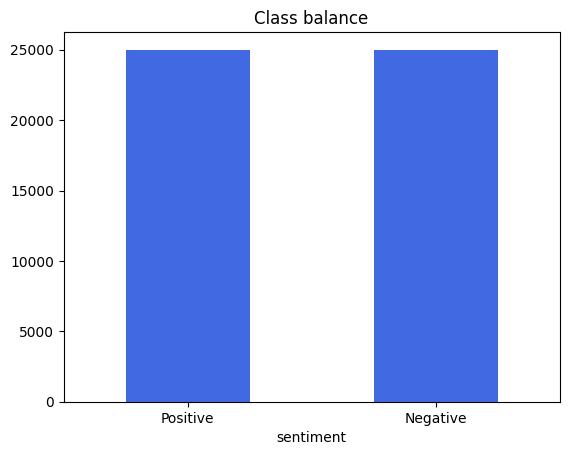

In [5]:
df['sentiment'].value_counts().plot(kind = 'bar', color = 'royalblue')
plt.xticks([0, 1],labels = ['Positive', 'Negative'], rotation = 0)
plt.title('Class balance')
plt.show()

In [6]:
df['review'].str.len().describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review, dtype: float64

In [7]:

print("Positive Review Example: \n")
print(df[df['sentiment'] == 1]['review'].iloc[0][:500])

print("\nNegative Review Example: \n")
print(df[df['sentiment'] == 0]['review'].iloc[0][:500])

Positive Review Example: 

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ

Negative Review Example: 

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. An

Neural networks cannot process raw text.
We convert text into numerical sequences while preserving word order so that recurrent models can learn temporal dependencies.

# Text Preprocessing

Neural networks cannot process raw text directly.
We apply minimal preprocessing to preserve sentiment-critical words.

Preprocessing steps:

- Convert text to lowercase

- Remove HTML tags

- Normalize whitespace

Stopwords and punctuation are not removed, as they often carry sentiment information.

In [8]:
def clean_text(text):
    text = text.lower()
    # remove HTML tags
    text = re.sub(r'<.*?>', "", text)
    # remove extra spaces
    text = re.sub(r'\s+', " ", text)
    return text.strip()

df['clean_review'] = df['review'].apply(clean_text)

## Tokenization
we covert words -> integers using a fixed vocabulary

## Word Frequencies

In [9]:
counter = Counter()

for review in df['clean_review']:
    counter.update(review.split())

MAX_VOCAB_SIZE = 20000

most_common = counter.most_common(MAX_VOCAB_SIZE - 2)

## Word -> Index Mapping

- 0 reserved for padding
- 1 reserved for unknown words

In [10]:
# special tokens
PAD_TOKEN = "<PAD>" #padding
OOV_TOKEN = "<OOV>" # out of vocabulary

word2idx = {
    PAD_TOKEN: 0,
    OOV_TOKEN: 1
}

for idx, (word, _) in enumerate(most_common, start = 2):
    word2idx[word] = idx

vocab_size = len(word2idx)    
print("Vocabulary Size: ",vocab_size)

Vocabulary Size:  20000


In [24]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(word2idx, f)


## Text -> Integer Sequences

In [11]:
def encode_review(review, word2idx):
    return [
        word2idx.get(word, word2idx[OOV_TOKEN])
        for word in review.split()
    ]

sequences = df['clean_review'].apply(lambda x: encode_review(x, word2idx))

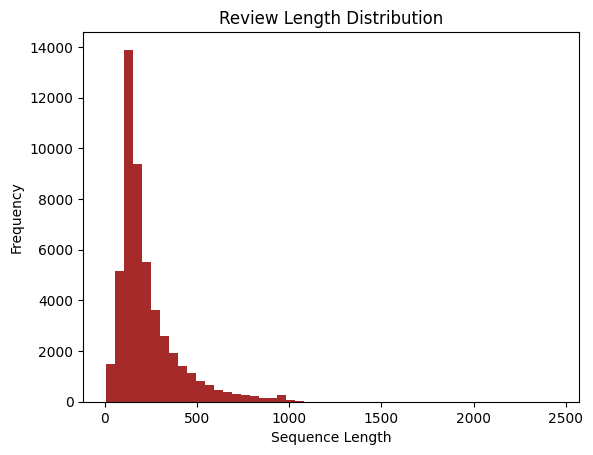

In [12]:
lengths = sequences.apply(len)
plt.hist(lengths, bins = 50, color = 'brown')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title("Review Length Distribution")
plt.show()

## Padding and Truncation

In [13]:
MAX_LEN = 400

def pad_sequence(seq, max_len):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [word2idx[PAD_TOKEN]] * (max_len - len(seq))

X = sequences.apply(lambda x: pad_sequence(x, MAX_LEN))

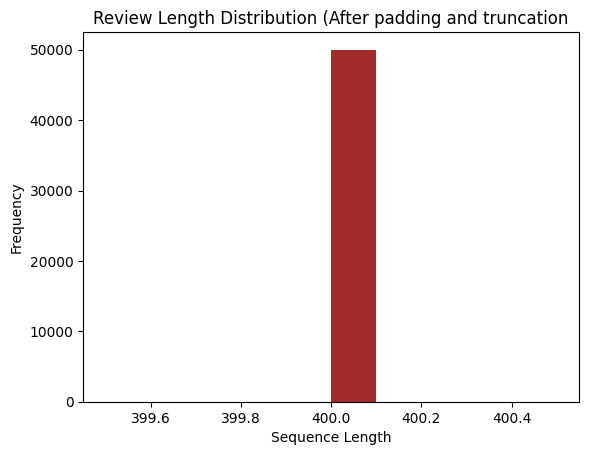

In [14]:
lengths = X.apply(len)
plt.hist(lengths, bins = 10, color = 'brown')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title("Review Length Distribution (After padding and truncation")
plt.show()

## Labels

In [15]:
y = df['sentiment'].values

## Convert to PyTorch Tensors

In [16]:
X_train, X_val, y_train, y_val = train_test_split(list(X), y, test_size = 0.2, random_state = 42,
                                                 stratify = y)
X_train = torch.tensor(X_train, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.long)

y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

X_train.shape, y_train.shape

(torch.Size([40000, 400]), torch.Size([40000]))

In [17]:
class CustomDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [18]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader  = DataLoader(val_dataset, batch_size = 64)

# Baseline Model: Simple RNN

A Simple RNN is used as a baseline to highlight the limitations of vanilla recurrent architectures, especially for long sequences.

Architecture

- Embedding layer

- Simple RNN

- Fully connected layer

- Sigmoid activation

Only the final hidden state is used for classification, following a many-to-one setup.

In [19]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(SimpleRNN, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = embed_dim,
            padding_idx = 0
        )
        self.embedding_dropout = nn.Dropout(0.3)

        self.rnn = nn.RNN(
            input_size = embed_dim,
            hidden_size = hidden_dim,
            batch_first = True
        )

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # print(x)
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        # print(embedded)

        output, hidden = self.rnn(embedded)

        last_hidden = hidden[-1]
        logits = self.fc(last_hidden)
        probs = self.sigmoid(logits)

        return probs.squeeze()

In [20]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMBED_DIM = 128
HIDDEN_DIM = 128

model = SimpleRNN(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM
).to(DEVICE)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)


In [21]:
def train_one_epoch(model, loader, optimizer, criterion,threshold = 0.5):
    model.train()
    total_loss, correct = 0, 0

    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += ((preds >= threshold) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


In [22]:
def evaluate(model, loader, criterion, threshold = 0.5):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)

            preds = model(X)
            loss = criterion(preds, y)

            total_loss += loss.item()
            correct += ((preds >= threshold) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


In [199]:
EPOCHS = 10

rnn_train_losses, rnn_val_losses = [], []
rnn_train_accs, rnn_val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    rnn_train_losses.append(train_loss)
    rnn_val_losses.append(val_loss)
    rnn_train_accs.append(train_acc)
    rnn_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.6947, Train Acc: 0.5010
Val   Loss: 0.6935, Val   Acc: 0.5078
Epoch 2/10
Train Loss: 0.6944, Train Acc: 0.5075
Val   Loss: 0.6932, Val   Acc: 0.5085
Epoch 3/10
Train Loss: 0.6946, Train Acc: 0.5022
Val   Loss: 0.6929, Val   Acc: 0.5105
Epoch 4/10
Train Loss: 0.6944, Train Acc: 0.5057
Val   Loss: 0.6934, Val   Acc: 0.4999
Epoch 5/10
Train Loss: 0.6945, Train Acc: 0.5020
Val   Loss: 0.6930, Val   Acc: 0.4993
Epoch 6/10
Train Loss: 0.6947, Train Acc: 0.5046
Val   Loss: 0.6935, Val   Acc: 0.5000
Epoch 7/10
Train Loss: 0.6939, Train Acc: 0.5039
Val   Loss: 0.6964, Val   Acc: 0.4973
Epoch 8/10
Train Loss: 0.6935, Train Acc: 0.5102
Val   Loss: 0.6933, Val   Acc: 0.5045
Epoch 9/10
Train Loss: 0.6945, Train Acc: 0.5026
Val   Loss: 0.6979, Val   Acc: 0.4960
Epoch 10/10
Train Loss: 0.6947, Train Acc: 0.5019
Val   Loss: 0.6933, Val   Acc: 0.4980


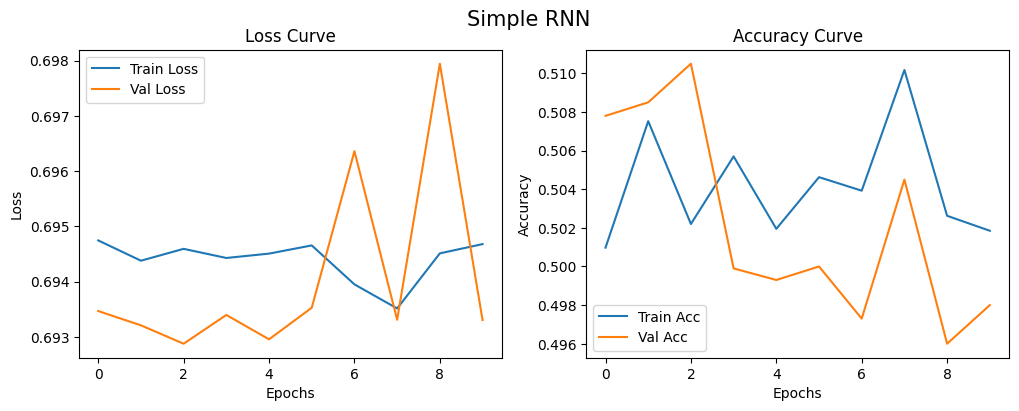

In [248]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rnn_train_losses, label="Train Loss")
plt.plot(rnn_val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_train_accs, label="Train Acc")
plt.plot(rnn_val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.suptitle('Simple RNN', fontsize = 15)
plt.show()


## Observations - Simple RNN

- Learns basic sentiment patterns

- Struggles with long-term dependencies

- Validation accuracy saturates early

- Exhibits unstable training behavior

These limitations motivate the use of gated architectures.

# Long Short-Term Memory (LSTM)
While Simple RNNs struggle with long-term dependencies due to vanishing gradients,
LSTMs introduce gated memory mechanisms that allow the network to retain and forget information selectively.

In [201]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0
        )
        self.embedding_dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
     
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
       
        output, (hidden, cell) = self.lstm(embedded)
     
        last_hidden = hidden[-1]
        logits = self.fc(last_hidden)
        probs = self.sigmoid(logits)

        return probs.squeeze()


In [202]:
model = LSTMModel(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM
).to(DEVICE)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)


In [203]:
EPOCHS = 10

lstm_train_losses, lstm_val_losses = [], []
lstm_train_accs, lstm_val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    lstm_train_losses.append(train_loss)
    lstm_val_losses.append(val_loss)
    lstm_train_accs.append(train_acc)
    lstm_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.6931, Train Acc: 0.5054
Val   Loss: 0.6924, Val   Acc: 0.5099
Epoch 2/10
Train Loss: 0.6913, Train Acc: 0.5111
Val   Loss: 0.6926, Val   Acc: 0.4997
Epoch 3/10
Train Loss: 0.6922, Train Acc: 0.5110
Val   Loss: 0.6945, Val   Acc: 0.4994
Epoch 4/10
Train Loss: 0.6950, Train Acc: 0.4988
Val   Loss: 0.6930, Val   Acc: 0.5062
Epoch 5/10
Train Loss: 0.6945, Train Acc: 0.5030
Val   Loss: 0.6930, Val   Acc: 0.5084
Epoch 6/10
Train Loss: 0.6939, Train Acc: 0.5017
Val   Loss: 0.6980, Val   Acc: 0.5003
Epoch 7/10
Train Loss: 0.6939, Train Acc: 0.4998
Val   Loss: 0.6950, Val   Acc: 0.5021
Epoch 8/10
Train Loss: 0.6941, Train Acc: 0.5051
Val   Loss: 0.6965, Val   Acc: 0.4994
Epoch 9/10
Train Loss: 0.6933, Train Acc: 0.5081
Val   Loss: 0.6932, Val   Acc: 0.5083
Epoch 10/10
Train Loss: 0.6927, Train Acc: 0.5107
Val   Loss: 0.6934, Val   Acc: 0.4984


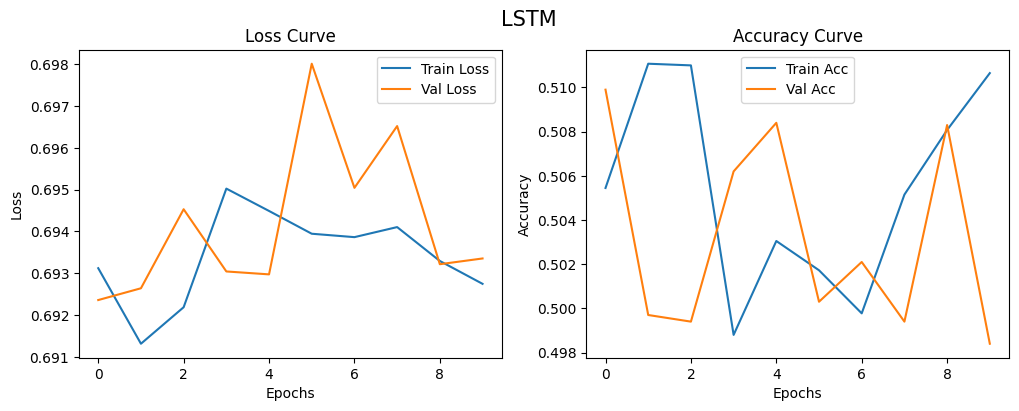

In [250]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(lstm_train_losses, label="Train Loss")
plt.plot(lstm_val_losses, label="Val Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_train_accs, label="Train Acc")
plt.plot(lstm_val_accs, label="Val Acc")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title("Accuracy Curve")
plt.legend()

plt.suptitle('LSTM', fontsize = 15)
plt.show()


## Observations - LSTM

- Faster convergence than Simple RNN

- Significantly higher validation accuracy

- Better generalization on long reviews

- Reduced training instability

# Gated Recurrent Unit (GRU)
GRU simplifies LSTM by combining gates, reducing parameter count while maintaining performance.
### Key Characteristics

- No separate cell state

- Fewer parameters

- Faster training

In [205]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0
        )
        self.embedding_dropout = nn.Dropout(0.3)

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x.shape: (batch_size, seq_len)
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        # embedded.shape: (batch_size, seq_len, embed_dim)

        output, hidden = self.gru(embedded)
        # hidden.sahpe: (1, batch_size, hidden_dim)

        last_hidden = hidden[-1]
        logits = self.fc(last_hidden)
        probs = self.sigmoid(logits)

        return probs.squeeze()


In [206]:
model = GRUModel(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM
).to(DEVICE)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)


In [207]:
EPOCHS = 10

gru_train_losses, gru_val_losses = [], []
gru_train_accs, gru_val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    gru_train_losses.append(train_loss)
    gru_val_losses.append(val_loss)
    gru_train_accs.append(train_acc)
    gru_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.6940, Train Acc: 0.5007
Val   Loss: 0.6932, Val   Acc: 0.4987
Epoch 2/10
Train Loss: 0.6919, Train Acc: 0.5086
Val   Loss: 0.6933, Val   Acc: 0.5015
Epoch 3/10
Train Loss: 0.6896, Train Acc: 0.5147
Val   Loss: 0.6938, Val   Acc: 0.5120
Epoch 4/10
Train Loss: 0.6827, Train Acc: 0.5209
Val   Loss: 0.6951, Val   Acc: 0.5031
Epoch 5/10
Train Loss: 0.6653, Train Acc: 0.5532
Val   Loss: 0.6425, Val   Acc: 0.6756
Epoch 6/10
Train Loss: 0.6464, Train Acc: 0.5828
Val   Loss: 0.7050, Val   Acc: 0.5167
Epoch 7/10
Train Loss: 0.6161, Train Acc: 0.6282
Val   Loss: 0.5048, Val   Acc: 0.7685
Epoch 8/10
Train Loss: 0.3088, Train Acc: 0.8714
Val   Loss: 0.2899, Val   Acc: 0.8835
Epoch 9/10
Train Loss: 0.1775, Train Acc: 0.9339
Val   Loss: 0.2731, Val   Acc: 0.8906
Epoch 10/10
Train Loss: 0.1191, Train Acc: 0.9600
Val   Loss: 0.3058, Val   Acc: 0.8910


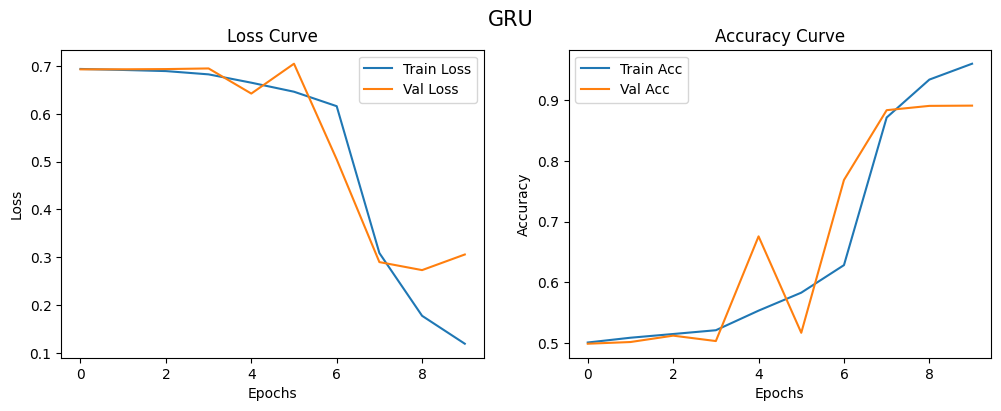

In [251]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gru_train_losses, label="Train Loss")
plt.plot(gru_val_losses, label="Val Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_train_accs, label="Train Acc")
plt.plot(gru_val_accs, label="Val Acc")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title("Accuracy Curve")
plt.legend()

plt.suptitle('GRU', fontsize = 15)
plt.show()



## Observations - GRU

- Comparable accuracy to LSTM

- Faster convergence

- More computationally efficient

- Strong performance with reduced complexity

# Bidirectional LSTM (BiLSTM)
Understanding sentiment often requires both past and future context.

Bidirectional LSTM processes sequences in:

- Forward direction

- Backward direction

This enables richer contextual representations.

In [25]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(BiLSTMModel, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0
        )

        
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            dropout=0.3,
            batch_first=True,
            bidirectional=True,
            num_layers = 2
        )

        # hidden_dim * 2 because of forward + backward
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

        self.embedding_dropout = nn.Dropout(0.3)
        self.fc_dropout = nn.Dropout(0.3)
    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        # embedded: (batch_size, seq_len, embed_dim)

        output, (hidden, cell) = self.lstm(embedded)
        # hidden: (2, batch_size, hidden_dim)

        forward_hidden = hidden[-2]
        backward_hidden = hidden[-1]

        # forward last hidden + backward last hidden
        combined = torch.cat((forward_hidden, backward_hidden), dim=1)
        combined = self.fc_dropout(combined)
        logits = self.fc(combined)
        probs = self.sigmoid(logits)

        return probs.squeeze()


In [26]:
model = BiLSTMModel(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM
).to(DEVICE)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)


In [27]:
EPOCHS = 10

bilstm_train_losses, bilstm_val_losses = [], []
bilstm_train_accs, bilstm_val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    bilstm_train_losses.append(train_loss)
    bilstm_val_losses.append(val_loss)
    bilstm_train_accs.append(train_acc)
    bilstm_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.6557, Train Acc: 0.6093
Val   Loss: 0.6600, Val   Acc: 0.5843
Epoch 2/10
Train Loss: 0.5683, Train Acc: 0.7030
Val   Loss: 0.4723, Val   Acc: 0.7746
Epoch 3/10
Train Loss: 0.4032, Train Acc: 0.8223
Val   Loss: 0.3307, Val   Acc: 0.8576
Epoch 4/10
Train Loss: 0.3191, Train Acc: 0.8685
Val   Loss: 0.3048, Val   Acc: 0.8737
Epoch 5/10
Train Loss: 0.2801, Train Acc: 0.8873
Val   Loss: 0.2741, Val   Acc: 0.8889
Epoch 6/10
Train Loss: 0.2522, Train Acc: 0.9012
Val   Loss: 0.2696, Val   Acc: 0.8915
Epoch 7/10
Train Loss: 0.2080, Train Acc: 0.9234
Val   Loss: 0.2633, Val   Acc: 0.8942
Epoch 8/10
Train Loss: 0.1714, Train Acc: 0.9363
Val   Loss: 0.2675, Val   Acc: 0.8949
Epoch 9/10
Train Loss: 0.1459, Train Acc: 0.9483
Val   Loss: 0.2993, Val   Acc: 0.8941
Epoch 10/10
Train Loss: 0.1208, Train Acc: 0.9581
Val   Loss: 0.3013, Val   Acc: 0.8929


In [28]:
torch.save(model.state_dict(), "model.pth")

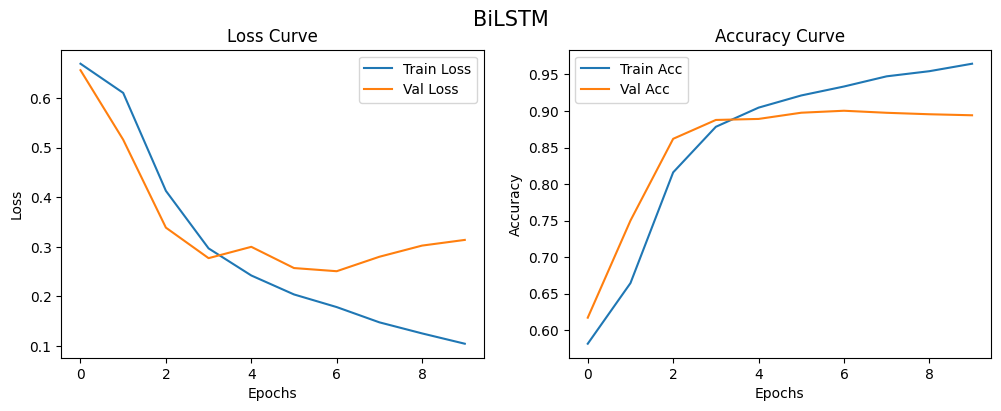

In [253]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(bilstm_train_losses, label="Train Loss")
plt.plot(bilstm_val_losses, label="Val Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bilstm_train_accs, label="Train Acc")
plt.plot(bilstm_val_accs, label="Val Acc")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title("Accuracy Curve")
plt.legend()

plt.suptitle('BiLSTM', fontsize = 15)
plt.show()




## Observations - BiLSTM

- Best validation performance among all models

- More stable convergence

- Better handling of negations and contrastive phrases

- Higher computational cost

In [213]:
histories = {
    "Simple RNN": {'train_acc':rnn_train_accs, 'val_acc':rnn_val_accs},
    "LSTM": {'train_acc':lstm_train_accs, 'val_acc':lstm_val_accs},
    "GRU": {'train_acc':gru_train_accs, 'val_acc':gru_val_accs},
    "BiLSTM": {'train_acc':bilstm_train_accs, 'val_acc':bilstm_val_accs}
}

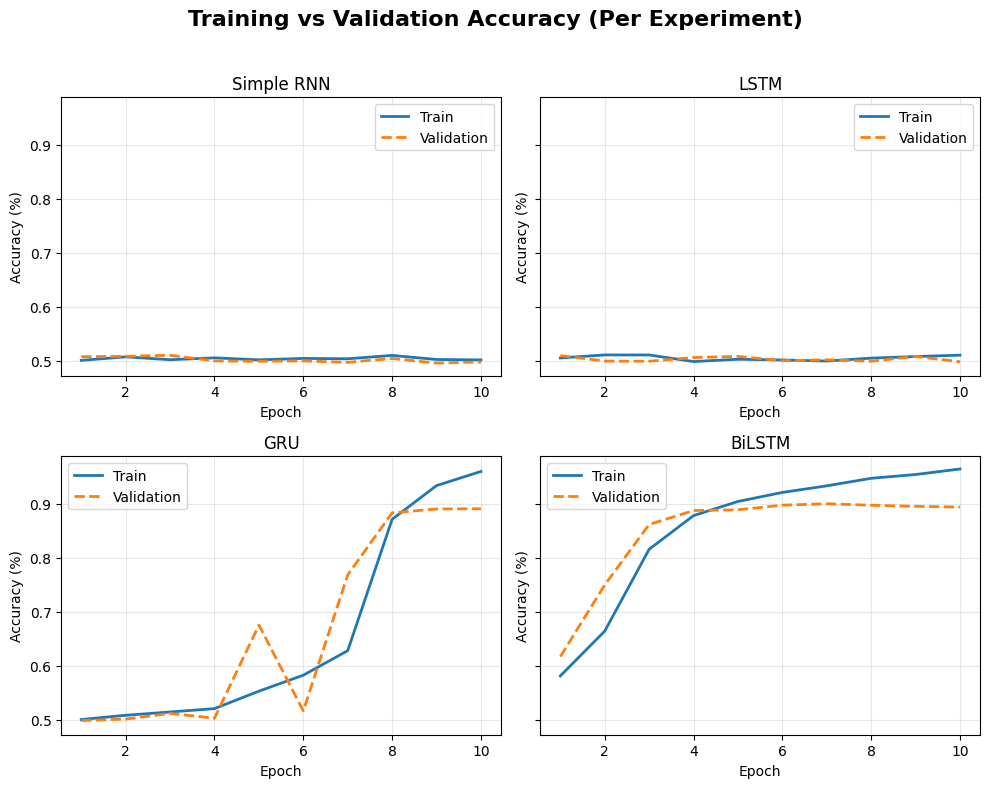

In [214]:
num_plots = len(histories)
cols = 2
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(
    rows, cols,
    figsize=(10, 4 * rows),
    sharex=False,
    sharey=True
)

axes = axes.flatten()

for idx, (name, hist) in enumerate(histories.items()):
    ax = axes[idx]
    epochs = range(1, len(hist["train_acc"]) + 1)

    ax.plot(
        epochs,
        hist["train_acc"],
        label="Train",
        linewidth=2
    )
    ax.plot(
        epochs,
        hist["val_acc"],
        label="Validation",
        linestyle="--",
        linewidth=2
    )

    ax.set_title(name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.grid(True, alpha=0.3)
    ax.legend()

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(
    "Training vs Validation Accuracy (Per Experiment)",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Model Comparison Summary

| Model      | Validation Accuracy | Training Speed | Parameters |
| ---------- | ------------------- | -------------- | ---------- |
| Simple RNN | Low                 | Fast           | Low        |
| LSTM       | High                | Medium         | High       |
| GRU        | High                | Fast           | Medium     |
| **BiLSTM** | **Highest**         | Slowest        | Highest    |


## Evaluation Using ROC-AUC (Final Model)

In [215]:
def evaluate_roc_auc(model, loader):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            probs = model(X)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.numpy())

    auc = roc_auc_score(all_labels, all_probs)
    return auc, all_labels, all_probs


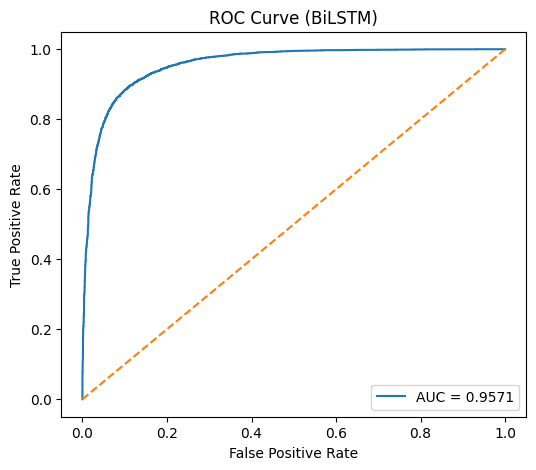

In [221]:
auc, y_true, y_probs = evaluate_roc_auc(model, val_loader)

fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BiLSTM)")
plt.legend()
plt.show()


## Threshold Selection
Instead of using a fixed 0.5 threshold, an optimal threshold was selected based on Youden’s J statistic, balancing true positive and false positive rates.

In [222]:
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)

best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)


Best threshold: 0.7703423


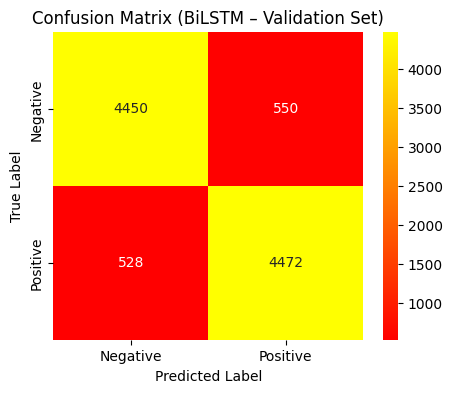

In [244]:
# convert probabilities -> predictions
y_val_pred = (np.array(y_probs) >= best_threshold).astype(int)

# compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="autumn",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (BiLSTM – Validation Set)")
plt.show()

This project demonstrates a systematic comparison of recurrent neural network architectures for sentiment analysis.

- Gated architectures significantly outperform Simple RNNs

- GRU offers an excellent trade-off between speed and performance

- BiLSTM achieves the best results by leveraging bidirectional context

- Proper regularization and ROC-based evaluation further improve robustness

## Future Work

- Attention mechanism on top of BiLSTM

- Pretrained embeddings (GloVe / FastText)

In [254]:
def preprocess_single_text(text, word2idx, max_len):
    text = clean_text(text)
    tokens = text.split()

    encoded = [
        word2idx.get(word, word2idx["<OOV>"])
        for word in tokens
    ]

    if len(encoded) >= max_len:
        encoded = encoded[:max_len]
    else:
        encoded = encoded + [word2idx["<PAD>"]] * (max_len - len(encoded))

    return torch.tensor(encoded, dtype=torch.long).unsqueeze(0)


In [255]:
def predict_sentiment(text, model, word2idx, max_len, threshold=0.5):
    model.eval()

    input_tensor = preprocess_single_text(text, word2idx, max_len)
    input_tensor = input_tensor.to(DEVICE)

    with torch.no_grad():
        prob = model(input_tensor).item()

    label = "Positive" if prob >= threshold else "Negative"

    return label, prob


Prediction: Negative
Confidence: 0.0575


In [258]:
samples = [
    "This movie was absolutely terrible and boring.",
    "An excellent film with great performances.",
    "Not bad, but could have been much better.",
    "I wouldn't recommend this movie to anyone."
]

for text in samples:
    label, prob = predict_sentiment(
        text, model, word2idx, MAX_LEN, best_threshold
    )
    print(f"{text}")
    print(f" → {label} ({prob:.3f})\n")


This movie was absolutely terrible and boring.
 → Negative (0.015)

An excellent film with great performances.
 → Positive (0.998)

Not bad, but could have been much better.
 → Negative (0.274)

I wouldn't recommend this movie to anyone.
 → Negative (0.164)

